# ***VAE for image generation***
Consider VAE model from
*Auto-Encoding Variational Bayes (2014, D.P. Kingma et. al.)*.  

We will implement a VAE model using Torch and apply it to the MNIST dataset.


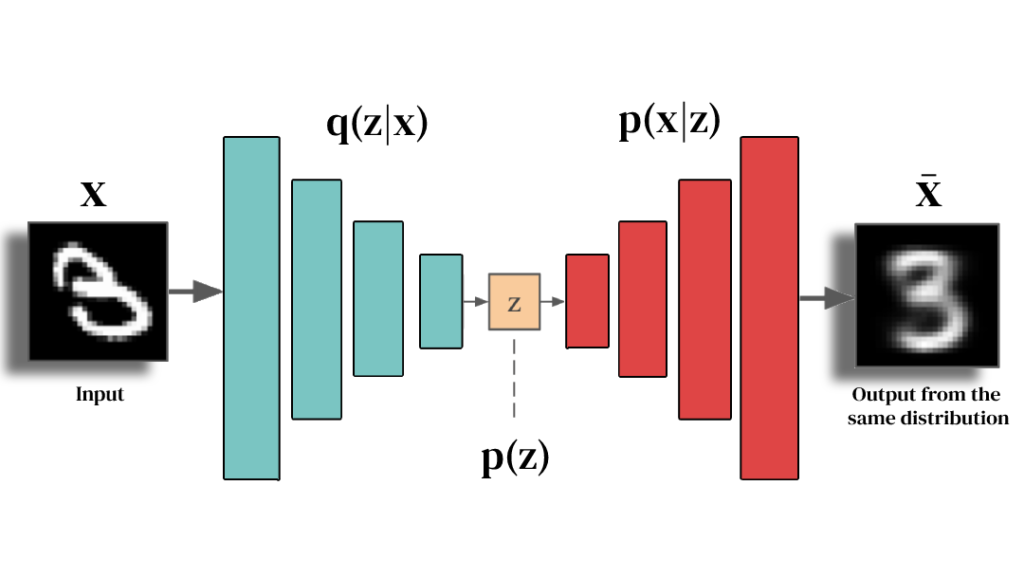


**Generative model:** We model each pixel value $\in \{0,1\}$ as a sample drawn from a Bernoulli distribution. Through a decoder, the latent random variable $z_n$  associated with an image $n$ is mapped to the success parameters of the Bernoulli distributions associated with the pixels of that image. Our generative model is described as follows:

$ z_n \sim N(0,I) $

$ \theta_n = g(z_n) $

$ x_n \sim Bern(\theta_n) $

where $g$ is the decoder. We choose the prior on $z_n$ to be the standard multivariate normal distribution, for computational convenience.  

**Inference model:** We infer the posterior distribution of $z_n$ via variational inference. The variational distribution $ q(z_n|x_n) $ is chosen to be multivariate Gaussian with a diagonal covariance matrix. The mean and covariance of this distribution are obtained by applying an encoder to $x_n$.

$ q(z_n|x_n) \sim q( \mu_n, \sigma^2_n) $

where $ \mu_n, \sigma^2_n = f(x_n)  $ and $f$ is the encoder.






**Implementation:**
Let's start with importing Torch and other necessary libraries:

In [ ]:
import torch
import torch.nn as nn

import numpy as np

from tqdm import tqdm
from torchvision.utils import save_image, make_grid

### ***Step1: Model Hyperparameters***



In [ ]:
dataset_path = '~/datasets'

batch_size = 100

# Dimensions of the input, the hidden layer, and the latent space.
x_dim  = 784
hidden_dim = 400
latent_dim = 200

# Learning rate
lr = 1e-3

# Number of epoch
epochs = 15 # can try something greater if you are not satisfied with the results

### ***Step2: Load Dataset***



In [ ]:
from torchvision.datasets import MNIST
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

mnist_transform = transforms.Compose([
        transforms.ToTensor(),
])


train_dataset = MNIST(dataset_path, transform=mnist_transform, train=True, download=True)
test_dataset  = MNIST(dataset_path, transform=mnist_transform, train=False, download=True)

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader  = DataLoader(dataset=test_dataset,  batch_size=batch_size, shuffle=False)

100%|██████████| 9912422/9912422 [00:00<00:00, 106152558.97it/s]

Extracting /root/datasets/MNIST/raw/train-images-idx3-ubyte.gz to /root/datasets/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 67485066.20it/s]


Extracting /root/datasets/MNIST/raw/train-labels-idx1-ubyte.gz to /root/datasets/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 37512564.39it/s]

Extracting /root/datasets/MNIST/raw/t10k-images-idx3-ubyte.gz to /root/datasets/MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 18212742.61it/s]

Extracting /root/datasets/MNIST/raw/t10k-labels-idx1-ubyte.gz to /root/datasets/MNIST/raw



### ***Step3: Define the model***


In [ ]:
class Encoder(nn.Module):
    # encoder outputs the parameters of variational distribution "q"
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(Encoder, self).__init__()

        self.FC_enc1 = nn.Linear(input_dim, hidden_dim) # FC stands for a fully connected layer
        self.FC_enc2 = nn.Linear(hidden_dim, hidden_dim)
        self.FC_mean = nn.Linear(hidden_dim, latent_dim)
        self.FC_var  = nn.Linear (hidden_dim, latent_dim)

        self.LeakyReLU = nn.LeakyReLU(0.2) # will use this to add non-linearity to our model

        self.training = True

    def forward(self, x):
        h_1     = self.LeakyReLU(self.FC_enc1(x))
        h_2     = self.LeakyReLU(self.FC_enc2(h_1))
        mean    = self.FC_mean(h_2)  # mean
        log_var = self.FC_var(h_2)   # log of variance

        return mean, log_var

In [ ]:
class Decoder(nn.Module):
    # decoder generates the success parameter of each pixel
    def __init__(self, latent_dim, hidden_dim, output_dim):
        super(Decoder, self).__init__()
        self.FC_dec1   = nn.Linear(latent_dim, hidden_dim)
        self.FC_dec2   = nn.Linear(hidden_dim, hidden_dim)
        self.FC_output = nn.Linear(hidden_dim, output_dim)

        self.LeakyReLU = nn.LeakyReLU(0.2) # again for non-linearity

    def forward(self, z):
        h_out_1  = self.LeakyReLU(self.FC_dec1(z))
        h_out_2  = self.LeakyReLU(self.FC_dec2(h_out_1))

        theta = torch.sigmoid(self.FC_output(h_out_2))
        return theta


**Q3.1** Below implement the reparameterization function.

In [ ]:
class Model(nn.Module):
    def __init__(self, Encoder, Decoder):
        super(Model, self).__init__()
        self.Encoder = Encoder
        self.Decoder = Decoder

    def reparameterization(self, mean, var):
        # insert your code here

        mu = torch.tensor( torch.zeros(200))
        cov = torch.eye(200)

        #print("here : ", np.shape(mean), np.shape(mean + var.mul(torch.distributions.MultivariateNormal(mu, cov).sample())))
        z = mean + var.mul(torch.distributions.MultivariateNormal(mu, cov).sample())

        return z


    def forward(self, x):
        mean, log_var = self.Encoder(x)
        z = self.reparameterization(mean, torch.exp(log_var)) # takes exponential function (log var -> var)

        theta = self.Decoder(z)

        return theta, mean, log_var

### ***Step4: Model initialization***


In [ ]:
encoder = Encoder(input_dim=x_dim, hidden_dim=hidden_dim, latent_dim=latent_dim)
decoder = Decoder(latent_dim=latent_dim, hidden_dim = hidden_dim, output_dim = x_dim)

model = Model(Encoder=encoder, Decoder=decoder)

### ***Step5: Loss function and optimizer***


Our objective function is ELBO:
$E_{q(z|x)}\big[\log \frac{p(x,z)}{q(z|x)}\big]$

* **Q5.1** Show that ELBO can be rewritten as:

  $E_{q(z|x)}\big(\log p(x|z)\big) - D_{KL} \big( q(z|x) \lvert \rvert  p(z)\big)$


*5.1 Your answer*

$E_{q(z|x)}\big[\log \frac{p(x|z)p(z)}{q(z|x)}\big] = $

$ = E_{q(z|x)}\big[\log p(x|z)\big] + E_{q(z|x)}\big[\log \frac{p(z)}{q(z|x)}\big] =$

$=E_{q(z|x)}\big(\log p(x|z)\big) - D_{KL} \big( q(z|x) \lvert \rvert  p(z)\big)$


Consider the first term: $E_{q(z|x)}\big(\log p(x|z)\big)$

$E_{q(z|x)}\big(\log p(x|z)\big) = \int q(z|x) \log p(x|z) dz $

We can approximate this integral by Monte Carlo integration as following:

$\approx \frac{1}{L} \sum_{l=1}^L \log p(x|z_l) $, where $z_l \sim q(z|x)$.

Now we can compute this term using the analytic expression for $p(x|z)$. ( Remember we model each pixel as a sample drawn from a Bernoulli distribution).

Consider the second term: $- D_{KL} \big( q(z|x) \lvert \rvert  p(z)\big)$

* **Q5.2** Kullback–Leibler divergence can be computed using the closed-form analytic expression when both the variational and the prior distributions are Gaussian. Write down this KL divergence in terms of the parameters of the prior and the variational distributions.

  *5.2 Your answer*

  $D_{KL} \big( q(z|x) \lvert \rvert  p(z)\big) = $

  $ \sum_{j=1}^{J} \int \frac{1}{\sqrt{2\pi \sigma_j^2}}e^{-\frac{(z_j-\mu_j)^2}{2\sigma_j^2}} \frac{\frac{1}{\sqrt{2\pi \sigma_j^2}}e^{-\frac{(z_j-\mu_j)^2}{2\sigma_j^2}}}{\frac{1}{\sqrt{2\pi \sigma_j^2}}e^{-\frac{z_j^2}{2}}} dz_j =$


  $=\sum_{j=1}^{J} [ \frac{1}{2}log \frac{1}{\sigma_j^2}+ \frac{1}{2\sigma_j^2}\underbrace{[-\int q(z_j|x)(x-\mu_j)^2dz_j]}_{\sigma_j^2}+ \frac{1}{2} \int \underbrace{z_j^2}_{z_j^2-\mu_j^2+\mu_j^2} q(z_j|x) dz_j]$


  $=\sum_{j=1}^{J} [ \frac{1}{2}log \frac{1}{\sigma_j^2}+ \frac{\sigma_j^2}{2\sigma_j^2}+\frac{1}{2}[ \underbrace{\int (z_j-\mu_j)^2q(z_j|x)dz_j}_{\sigma_j^2}+2\mu_j \underbrace{\int(z_j-\mu_j)q(z_j|\mu_j)dz_j}_{0}+\mu_j^2 \underbrace{\int q(z_j|x)dz_j}_1]]= $

  $\sum_{j=1}^{J} [\frac{1}{2}[\mu_j^2+\sigma_j^2-1- log \sigma_j^2]]$

**Q5.3** Now use your findings to implement the loss function, which is the negative of ELBO:

In [ ]:
from torch.optim import Adam

def loss_function(x, theta, mean, log_var): # should return the loss function (- ELBO)
    # insert your code here
    D_KL_batch = 0
    log_p_batch = 0

    mu_square = mean.mul(mean)
    sigma_square = torch.exp(log_var)
    log_sigma_square = log_var
    ones = torch.ones([100,200])
    D_KL = torch.sum((1/2)*(mu_square+sigma_square-ones-log_sigma_square))/(latent_dim+batch_size )

    log_p = torch.sum(x*torch.log(theta)+(1-x)*torch.log(1-theta))/(x_dim+batch_size)

    elbo = log_p - D_KL
    return -elbo

# optimizer
optimizer = Adam(model.parameters(), lr=lr)

### ***Step6: Train the model***


In [ ]:
print("Start training VAE...")
model.train()

for epoch in range(epochs):
    overall_loss = 0
    for batch_idx, (x, _) in enumerate(train_loader):
        x = x.view(batch_size, x_dim)
        x = torch.round(x)

        optimizer.zero_grad()

        theta, mean, log_var = model(x)
        loss = loss_function(x, theta, mean, log_var)

        #print(loss)
        overall_loss += loss.item()

        loss.backward()
        optimizer.step()

    print("\tEpoch", epoch + 1, "complete!", "\tAverage Loss: ", overall_loss / (batch_idx*batch_size))

print("Finish!!")

Start training VAE...


<ipython-input-6-42029324b075>:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mu = torch.tensor( torch.zeros(200))


	Epoch 1 complete! 	Average Loss:  0.23887394444970336
	Epoch 2 complete! 	Average Loss:  0.2140158712804218
	Epoch 3 complete! 	Average Loss:  0.20165153143600947
	Epoch 4 complete! 	Average Loss:  0.1954506854660722
	Epoch 5 complete! 	Average Loss:  0.19123159478622206
	Epoch 6 complete! 	Average Loss:  0.18747465447312803
	Epoch 7 complete! 	Average Loss:  0.18305275437827898
	Epoch 8 complete! 	Average Loss:  0.17897194316271747
	Epoch 9 complete! 	Average Loss:  0.1736080394802189
	Epoch 10 complete! 	Average Loss:  0.1681111281304208
	Epoch 11 complete! 	Average Loss:  0.16118962233771067
	Epoch 12 complete! 	Average Loss:  0.1543029543951477
	Epoch 13 complete! 	Average Loss:  0.1476816320021284
	Epoch 14 complete! 	Average Loss:  0.14310601912675197
	Epoch 15 complete! 	Average Loss:  0.13834431449240556
Finish!!


### ***Step7: Generate images from test dataset***
With our model trained, now we can start generating images.

First, we will generate images from the latent representations of test data.

Basically, we will sample $z$ from $q(z|x)$ and give it to the generative model (i.e., decoder) $p(x|z)$. The output of the decoder will be displayed as the generated image.

**Q7.1** Write a code to get the reconstructions of test data, and then display them using the show_image function

In [ ]:
model.eval()
# below we get decoder outputs for test data
with torch.no_grad():
    for batch_idx, (x, _) in enumerate(tqdm(test_loader)):
        x = x.view(batch_size, x_dim)

        x = x.view(batch_size, x_dim)
        x = torch.round(x)

        optimizer.zero_grad()


        # insert your code below to generate theta from x
        theta, mean, log_var = model(x)


  0%|          | 0/100 [00:00<?, ?it/s]<ipython-input-6-42029324b075>:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mu = torch.tensor( torch.zeros(200))
100%|██████████| 100/100 [00:01<00:00, 50.97it/s]


A helper function to display images:

In [ ]:
import matplotlib.pyplot as plt
def show_image(theta, idx):
    x_hat = theta.view(batch_size, 28, 28)
    #x_hat = Bernoulli(x_hat).sample() # sample pixel values (you can also try this, and observe how the generated images look)
    fig = plt.figure()
    plt.imshow(x_hat[idx].cpu().numpy(), cmap='gray')

First display an image from the test dataset,

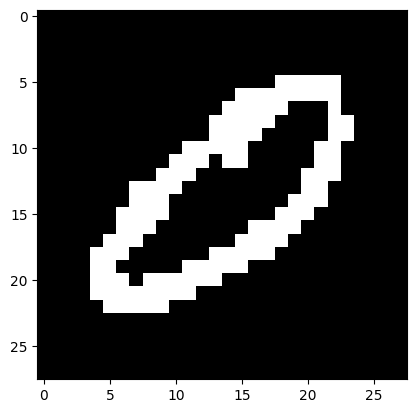

In [ ]:
show_image(x, idx=2) # try different indices as well

Now display its reconstruction and compare:

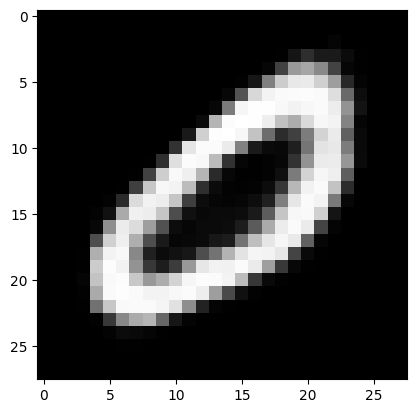

In [ ]:
show_image(theta, idx=2)

### ***Step8: Generate images from noise***

In the previous step, we sampled latent vector $z$ from $q(z|x)$. However, we know that the KL term in our loss function enforced $q(z|x)$ to be close to $N(0, I)$. Therefore, we can sample $z$ directly from noise $N(0, I)$, and pass it to the decoder $p(x|z)$.



**Q8.1** Create images from noise and display.

In [ ]:
with torch.no_grad():



    generated_images = torch.tensor(torch.zeros([batch_size,x_dim]))
    mu = torch.tensor( torch.zeros(200))
    cov = torch.eye(200)

    for i in range(batch_size):
        z = torch.distributions.MultivariateNormal(mu, cov).sample()
        generated_images[i] = decoder(z)
    #print("here : ", np.shape(mean), np.shape(mean + var.mul(torch.distributions.MultivariateNormal(mu, cov).sample())))


    # insert your code here to create images from noise (it is enough to create theta value for each pixel)
    #
    #
    # generated_images = ....  # should be a matrix ( batch_size-by-x_dim )

<ipython-input-14-706fc1bc5e21>:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  generated_images = torch.tensor(torch.zeros([batch_size,x_dim]))
<ipython-input-14-706fc1bc5e21>:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mu = torch.tensor( torch.zeros(200))


Display a couple of generated images:

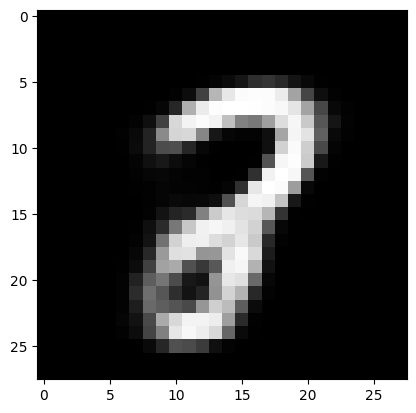

In [ ]:
show_image(generated_images, idx=25)